## 掛接 Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
import cv2
import tensorflow_datasets as tfds
import tensorflow.keras.layers as layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from tensorflow.keras.applications.vgg16 import VGG16
from tqdm import tqdm,trange
from PIL import Image
import warnings

from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D, Concatenate
from keras.applications.inception_v3 import InceptionV3

## 載入資料

In [ ]:
# 確認壓縮檔路徑
filepath='/content/drive/MyDrive/CVFinal/'
os.listdir(filepath)

['dataset.zip', 'E94074029Final.ipynb']

In [ ]:
# 解壓縮檔案
!unzip '/content/drive/MyDrive/CVFinal/dataset.zip' -d '/content/drive/MyDrive/CVFinal/'

串流輸出內容已截斷至最後 5000 行。
  inflating: /content/drive/MyDrive/CVFinal/dataset/train/馬鈴薯燉肉/38407.jpg  
  inflating: /content/drive/MyDrive/CVFinal/dataset/train/馬鈴薯燉肉/38409.jpg  
  inflating: /content/drive/MyDrive/CVFinal/dataset/train/馬鈴薯燉肉/38410.jpg  
  inflating: /content/drive/MyDrive/CVFinal/dataset/train/馬鈴薯燉肉/38411.jpg  
  inflating: /content/drive/MyDrive/CVFinal/dataset/train/馬鈴薯燉肉/38412.jpg  
  inflating: /content/drive/MyDrive/CVFinal/dataset/train/馬鈴薯燉肉/38414.jpg  
  inflating: /content/drive/MyDrive/CVFinal/dataset/train/馬鈴薯燉肉/38417.jpg  
  inflating: /content/drive/MyDrive/CVFinal/dataset/train/馬鈴薯燉肉/38418.jpg  
  inflating: /content/drive/MyDrive/CVFinal/dataset/train/馬鈴薯燉肉/38421.jpg  
  inflating: /content/drive/MyDrive/CVFinal/dataset/train/馬鈴薯燉肉/38423.jpg  
  inflating: /content/drive/MyDrive/CVFinal/dataset/train/馬鈴薯燉肉/38424.jpg  
  inflating: /content/drive/MyDrive/CVFinal/dataset/train/馬鈴薯燉肉/38425.jpg  
  inflating: /content/drive/MyDrive/CVFinal/dataset/train/馬鈴薯燉肉/384

In [ ]:
dirpath='/content/drive/MyDrive/CVFinal/dataset/'
os.listdir(dirpath) 

['test', 'train']

##資料前處理

In [ ]:
folder_path = '/content/drive/MyDrive/CVFinal/dataset/train/'

#detect image with Transparency expressed or not the image

# for fldr in os.listdir(folder_path):
#   sub_folder_path = os.path.join(folder_path, fldr)
#   for filee in os.listdir(sub_folder_path):
#     file_path = os.path.join(sub_folder_path, filee)
#     print('**Path: {} **'.format(file_path), end="\r", flush=True)
#     print(file_path)
#     im = Image.open(file_path)
#     rgb_im = im.convert('RGB')

#發現有機小松菜內有其他檔案將其移除
#發現有機青松菜內有其他檔案將其移除

#刪除重複的圖片
!pip install imagecleaner
!image-cleaner folder_path


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
imgSize=(299,299)
imgShape=(299,299,3)
batchSize=32

# train generator
trainDataGenerator = ImageDataGenerator(rescale = 1/255, horizontal_flip = True,
                               rotation_range=20,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2, 
                               zoom_range=0.3,
                               fill_mode="nearest"
                               )
valDataGenerator = ImageDataGenerator(rescale = 1/255,)

trainBatch = trainDataGenerator.flow_from_directory(
    directory = dirpath+'train',
    target_size = imgSize,
    class_mode = 'categorical',
    shuffle = True,
    batch_size = batchSize,
    subset='training'
)

valBatch = valDataGenerator.flow_from_directory(
    directory = dirpath+'test',
    target_size = imgSize,
    class_mode = 'categorical',
    shuffle = False,
    batch_size = batchSize,
)

Found 27903 images belonging to 50 classes.
Found 7002 images belonging to 50 classes.


## 載入模型

In [ ]:
base_model = InceptionV3(
    include_top = False,
    weights = 'imagenet',
    input_tensor = None,
    input_shape=imgShape,
)

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

output_layer = layers.Dense(units = 50, activation = 'softmax')(x)

# # freeze the weight
# base_model.trainable = False

model = tf.keras.Model(inputs = base_model.input, outputs = output_layer)
for layer in base_model.layers:
  layer.trainable=False

#model.summary()

# show the model stucture (截圖用)
model1 = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    tf.keras.layers.Dense(50, activation="softmax")
])
model1.summary()

87924736/87910968 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_3 (Dense)             (None, 50)                51250     
                                                                 
Total params: 23,952,210
Trainable params: 2,149,426
Non-trainable params: 21,802,784
_________________________________________________________________


## train model

In [ ]:
warnings.filterwarnings("ignore")

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k = 5, name = 'top_5_categorical_accuracy', dtype=None)])

epoch = 9
history = model.fit(
  trainBatch,
  steps_per_epoch = trainBatch.samples // batchSize,
  validation_data = valBatch,
  validation_steps = valBatch.samples // batchSize,
  epochs=epoch,
)

Epoch 1/9
871/871 [==============================] - 776s 867ms/step - loss: 1.7671 - accuracy: 0.5085 - top_5_categorical_accuracy: 0.8285 - val_loss: 1.2356 - val_accuracy: 0.6137 - val_top_5_categorical_accuracy: 0.9116
Epoch 2/9
871/871 [==============================] - 745s 855ms/step - loss: 1.1780 - accuracy: 0.6342 - top_5_categorical_accuracy: 0.9231 - val_loss: 1.0996 - val_accuracy: 0.6458 - val_top_5_categorical_accuracy: 0.9319
Epoch 3/9
871/871 [==============================] - 742s 852ms/step - loss: 1.0576 - accuracy: 0.6626 - top_5_categorical_accuracy: 0.9365 - val_loss: 1.0633 - val_accuracy: 0.6557 - val_top_5_categorical_accuracy: 0.9355
Epoch 4/9
871/871 [==============================] - 744s 854ms/step - loss: 0.9936 - accuracy: 0.6813 - top_5_categorical_accuracy: 0.9435 - val_loss: 0.9936 - val_accuracy: 0.6796 - val_top_5_categorical_accuracy: 0.9412
Epoch 5/9
871/871 [==============================] - 749s 860ms/step - loss: 0.9573 - accuracy: 0.6913 - top

## show the loss & accuracy curve

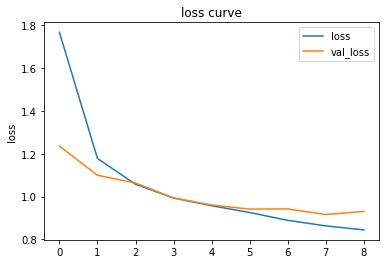

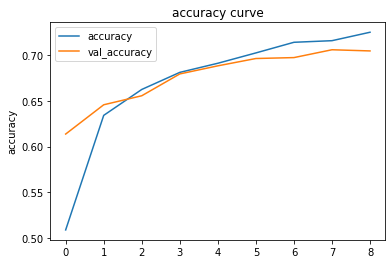

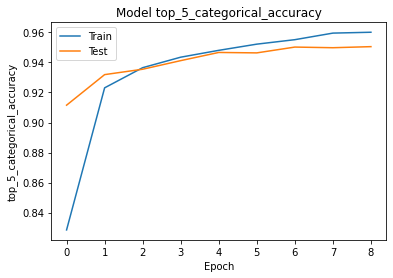

In [ ]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.title('loss curve')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.title('accuracy curve')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.plot(history.history['top_5_categorical_accuracy'])
plt.plot(history.history['val_top_5_categorical_accuracy'])
plt.title('Model top_5_categorical_accuracy')
plt.ylabel('top_5_categorical_accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Test'], loc = 'upper left')
plt.show()

##plot the confusion matrix and show the classification report

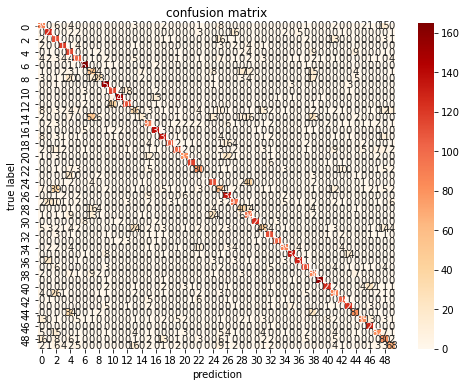

Classification Report
              precision    recall  f1-score   support

         三杯雞       0.50      0.66      0.57       134
        什錦炒麵       0.70      0.80      0.75       158
         咖哩雞       0.42      0.73      0.53       153
        塔香海茸       0.83      0.87      0.85       137
         大陸妹       0.44      0.79      0.57       144
        客家小炒       0.73      0.66      0.69       153
         小番茄       0.88      0.96      0.92       171
       有機小松菜       0.33      0.42      0.37       129
       有機青松菜       0.54      0.28      0.37        99
          木瓜       0.84      0.95      0.89       162
          柳丁       0.68      0.80      0.74       143
          棗子       0.93      0.86      0.89       173
          橘子       0.81      0.70      0.75       155
        沙茶肉片       0.38      0.28      0.32       128
          油菜       0.54      0.09      0.15       146
        洋蔥炒蛋       0.63      0.73      0.68       124
          滷蛋       0.86      0.90      0.88       155
     

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
import pandas as pd

#confusion matrix
Y_pred = model.predict(valBatch, valBatch.samples // batchSize+1)
y_pred = np.argmax(Y_pred, axis=1)
cm=confusion_matrix(valBatch.classes, y_pred)
fit=plt.figure(figsize=(8,6))
plt.title('confusion matrix')
sn.heatmap(cm,annot=True,cmap='OrRd',fmt='g')
plt.xlabel('prediction')
plt.ylabel('true label')
plt.show()

#classification report
print('Classification Report')
print(classification_report(valBatch.classes, y_pred, target_names=valBatch.class_indices.keys()))

#save the confusion matrix result as csv
df = pd.DataFrame(cm)
df.to_csv('/content/drive/MyDrive/CVFinal/confusion_matrix.csv')